# NMBACK BRANCH 


In [1]:
from glob import glob as glob
import numpy as np
from nmback import *

from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## closed loop training

In [23]:
ML = MetaLearner(stsize=20,nstim=3,edim=50)

In [24]:
trainer = Trainer(ML,nback=3,mback=3)

In [25]:
tr_acc,k_arr = trainer.train_close_loop(10000,thresh=.99)

0.0 0.36 k= 0
0.05 0.74 k= 0
0.1 0.9 k= 0
0.15 0.66 k= 7
0.2 0.9 k= 22
0.25 0.98 k= 39
0.3 0.96 k= 51
0.35 0.94 k= 65
0.4 0.8 k= 85
0.45 0.94 k= 101
0.5 0.84 k= 125
0.55 0.98 k= 152
0.6 0.84 k= 172
0.65 0.9 k= 206
0.7 0.98 k= 219
0.75 0.94 k= 249
0.8 0.86 k= 280
0.85 0.92 k= 310
0.9 0.96 k= 339
0.95 0.86 k= 347


Text(0.5,0,'trials')

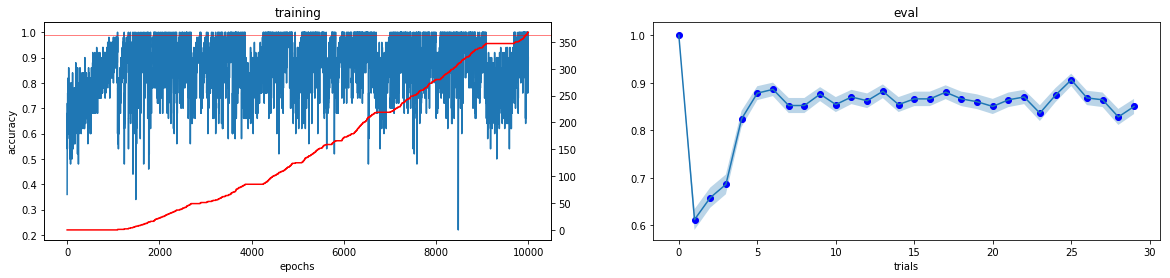

In [26]:
fig,axarr=plt.subplots(1,2,figsize=(20,4))
# train 
ax = axarr[0]
ax.plot(tr_acc)
ax.axhline(.99,c='r',lw=.5)
ax.set_ylabel('accuracy')
ax.twinx().plot(k_arr,c='r')
ax.set_title('training')
ax.set_xlabel('epochs')

# eval
ax = axarr[1]
eval_acc = trainer.eval_loop(500,30,0)
M = eval_acc.mean(0)
S = eval_acc.std(0)/np.sqrt(500)
ax.fill_between(range(len(M)),M+S,M-S,alpha=.3)
ax.plot(M)
ax.scatter(range(len(M)),M,c='blue')
ax.set_title('eval')
ax.set_xlabel('trials')
# plt.savefig('figures/lstm20-edim50-shallow2+do-closed_loop_training')

## training readout of N-1 and N+1

In [62]:
tpe=12
nback = 2
task = NMBackTask(nback,nback,nstim=3)
Xdata,Ydata = task.gen_seq(tpe,task_flag=0)
st_arr = trainer.unroll_states(Xdata)
net=ML
with net.graph.as_default():
  y_onehot = tf.one_hot(Ydata,2)
  dropout_lstmout = tf.keras.layers.Dropout(rate=(net.dropout_rate))
  readout = tf.keras.layers.Dense(2,activation=None,name='READOUT')
  logits = readout(dropout_lstmout(st_arr))
  train_loss = tf.nn.softmax_cross_entropy_with_logits_v2(
                  labels=y_onehot,
                  logits=logits)
  minimizer = tf.train.AdamOptimizer(0.001).minimize(train_loss)
#   print(tf.get_collection(tf.GraphKeys.))

  varL = net.sess.run(tf.report_uninitialized_variables())
  print([v.initializer for v in varL if type(v)==tf.Variable])
#   print(net.sess.run([v.initializer for v in tf.report_uninitialized_variables()]))
# _,loss = net.sess.run([minimizer,train_loss],{net.dropout_rate:0.1})
# print(loss)

[]


In [33]:
Ydata.shape,st_arr.shape

((1, 12), (1, 12, 20))

In [ ]:
net = ML
net.sess.run(net.randomize_stim_emat)

nepochs = 1000
acc_arr = -np.ones([nepochs])
st_arr = -np.ones([1,20,])

for epnum in range(nepochs):
  # train step
  self.train_step(Xdata,Ydata)
  # printing
  evalstep_acc = self.eval_step(Xdata,Ydata)
  acc_arr[epnum] = np.mean(evalstep_acc)
  if ep_num%(num_epochs/20) == 0:
    print(ep_num/num_epochs,np.mean(evalstep_acc)) 

## analyze lstm state
- fit PCA on k random sequences, on j random embeds. return pca object.
- given trained pca object and list of Xdata arrays, transform to PC space

In [398]:
def unroll_states_loop(trainer,num_embeds=500,seq_per_embed=10,seq_len=4):
  """ unroll states on random inputs
  """
  L = []
  for embed in range(num_embeds):
    trainer.net.sess.run(trainer.net.randomize_stim_emat)
    for seq in range(seq_per_embed):
      Xdata = np.random.randint(2,5,[1,seq_len])
      lstm_outputs = trainer.unroll_states(Xdata).squeeze()
      L.append(lstm_outputs)
  return np.concatenate(L)

def fit_st_traj_pca(trainer):
  """ fit pca on random inputs
  """
  states_arr = unroll_states_loop(trainer)
  print(states_arr.shape)
  pca = PCA(2)
  pca.fit(states_arr)
  return pca

pca = fit_st_traj_pca(trainer)

(20000, 20)


In [519]:
from sklearn.decomposition import PCA

# specify data
Xdata1 = Xdata3 = np.tile([3,3,4],3)
Xdata2 = np.tile([2,2,4],3)
Xdata1=Xdata3=np.array([2,2,2,2,2,3,3,3])
Xdata2=np.array([2,2,2,2,2,4,4,4])
data_arr = np.array([Xdata1,Xdata2,Xdata3])

# multiple random vectors
num_itr = 100
pc_traj_arr = -1*np.ones([num_itr,*data_arr.shape,2])

for itr in range(num_itr):
  # randomize vectors
  trainer.net.sess.run(trainer.net.randomize_stim_emat)

  # unroll state trajectories
  L = []
  for Xdata in data_arr:
    Xdata = np.expand_dims(Xdata,0)
    lstm_outputs = trainer.unroll_states(Xdata).squeeze()
    L.append(lstm_outputs)
  state_arr = np.stack(L)

  # compute PCA
  pc_traj = pca.transform(state_arr.reshape(-1,trainer.net.stsize)) # flatten for pca
  pc_traj = pc_traj.reshape([*data_arr.shape,2]) # seq,time,pc
  pc_traj_arr[itr] = pc_traj

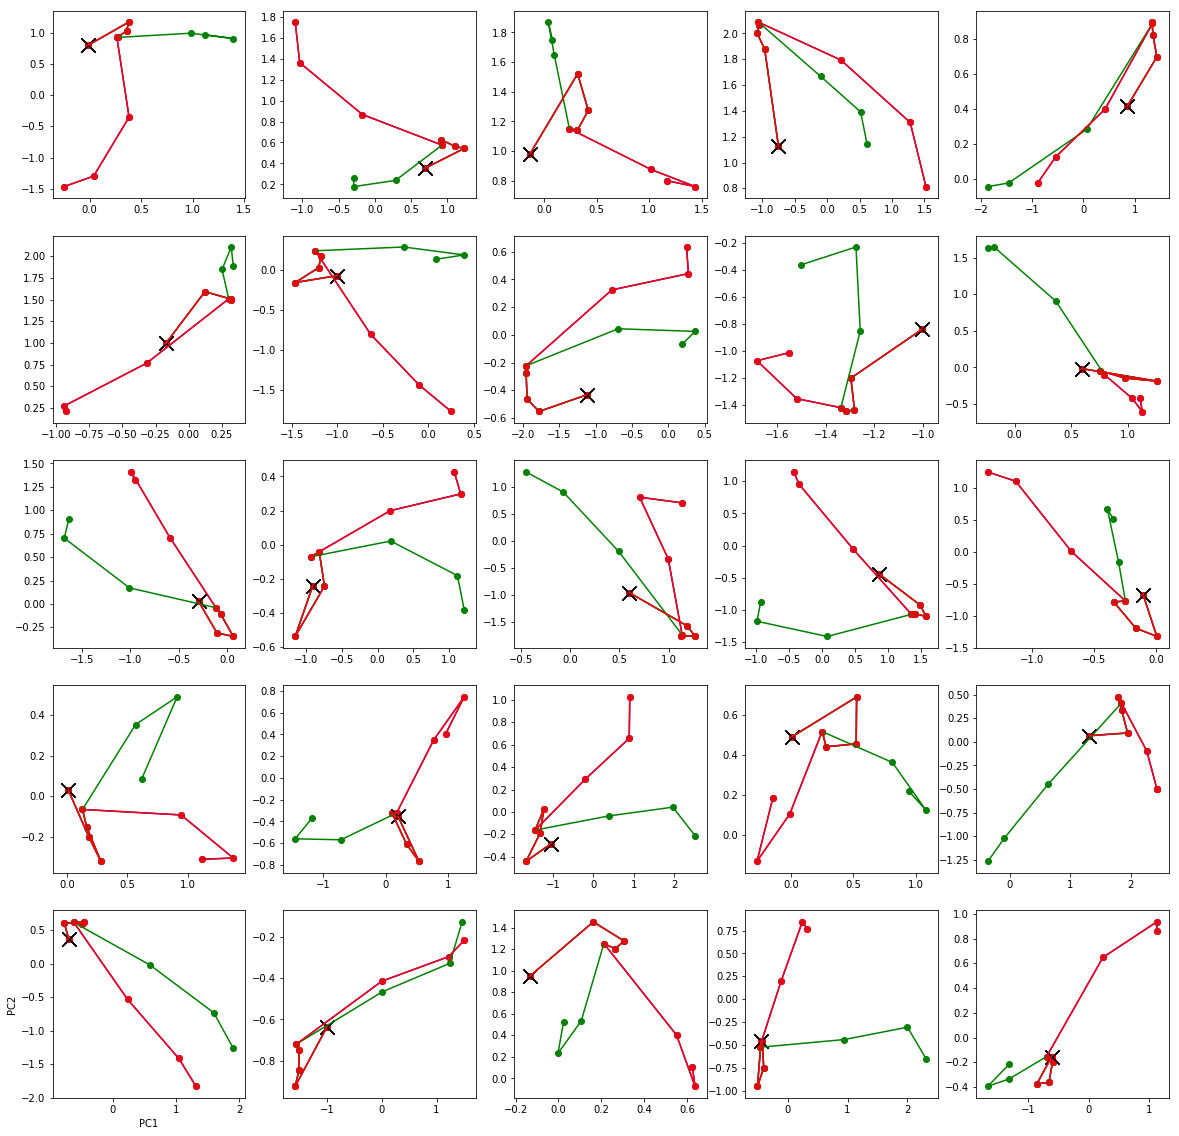

In [521]:
fig,axarr = plt.subplots(5,5,figsize=(20,20));axarr=axarr.reshape(-1)
seq_color = ['b','g','r']

i=-1
for pc_traj in pc_traj_arr[:25]:
  i+=1
  ax = axarr[i]
  for c,seq_traj in zip(seq_color,pc_traj):
    ax.plot(seq_traj[:,0],seq_traj[:,1],c=c)
    ax.scatter(seq_traj[:,0],seq_traj[:,1],c=c)
    ax.scatter(seq_traj[0,0],seq_traj[0,1],c='black',marker='x',s=200)

axarr[20].set_xlabel('PC1')
axarr[20].set_ylabel('PC2')
# plt.savefig('figures/nback_analysis/pc_st_traj-AAAC_AAAB-diff_inputs')

In [372]:
data_arr.shape,state_arr.shape,pc_traj_arr.shape

((3, 4), (3, 4, 20), (100, 3, 4, 2))

## analyze weight matrices

In [72]:
ML.graph.get_all_collection_keys()
K_var = ML.graph.get_collection('trainable_variables')[3]
K_mat = ML.sess.run(K_var)
K_mat.shape

(20, 80)

## save eval data at multiple points during training

In [350]:
ML = MetaLearner(stsize=30)
trainer = Trainer(ML,nback=2,mback=3)

train_nsess = 20
train_eps = 500

eval_ne = 1000
eval_tpe = 20

for sess in range(train_nsess):
  trainer.train_loop(train_eps,train_eps)
  eval_acc2 = trainer.eval_loop(eval_ne,eval_tpe,0)
  eval_acc3 = trainer.eval_loop(eval_ne,eval_tpe,1)
  np.save('model_data/LSTM30-23back-train_eps_%i-eval_2back-sess%i'%(train_eps,sess),eval_acc2)
  np.save('model_data/LSTM30-23back-train_eps_%i-eval_3back-sess%i'%(train_eps,sess),eval_acc3)

0.0 0.7
0.05 0.7
0.1 0.68
0.15 0.7
0.2 0.74
0.25 0.72
0.3 0.7
0.35 0.8
0.4 0.8
0.45 0.86
0.5 0.78
0.55 0.84
0.6 0.66
0.65 0.88
0.7 0.9
0.75 0.6
0.8 0.62
0.85 0.74
0.9 0.72
0.95 0.76
0.0 0.72
0.05 0.64
0.1 0.76
0.15 0.64
0.2 0.78
0.25 0.8
0.3 0.8
0.35 0.92
0.4 0.78
0.45 0.88
0.5 0.76
0.55 0.9
0.6 0.78
0.65 0.84
0.7 0.66
0.75 0.94
0.8 0.74
0.85 0.76
0.9 0.72
0.95 0.86
0.0 0.76
0.05 0.74
0.1 0.78
0.15 0.76
0.2 0.8
0.25 0.82
0.3 0.74
0.35 0.76
0.4 0.68
0.45 0.84
0.5 0.98
0.55 0.72
0.6 0.9
0.65 0.98
0.7 0.98
0.75 0.98
0.8 0.98
0.85 0.98
0.9 0.98
0.95 0.98
0.0 0.72
0.05 0.76
0.1 0.98
0.15 0.98
0.2 1.0
0.25 0.98
0.3 0.96
0.35 0.98
0.4 0.96
0.45 1.0
0.5 1.0
0.55 0.98
0.6 0.98
0.65 1.0
0.7 0.98
0.75 0.98
0.8 1.0
0.85 0.98
0.9 1.0
0.95 0.96
0.0 0.78
0.05 1.0
0.1 0.98
0.15 0.98
0.2 0.98
0.25 1.0
0.3 0.96
0.35 1.0
0.4 0.96
0.45 0.96
0.5 1.0
0.55 0.98
0.6 0.96
0.65 1.0
0.7 0.98
0.75 0.98
0.8 1.0
0.85 0.98
0.9 0.96
0.95 0.98
0.0 0.88
0.05 1.0
0.1 0.98
0.15 0.98
0.2 1.0
0.25 0.98
0.3 0.98
0.35 0.96
0

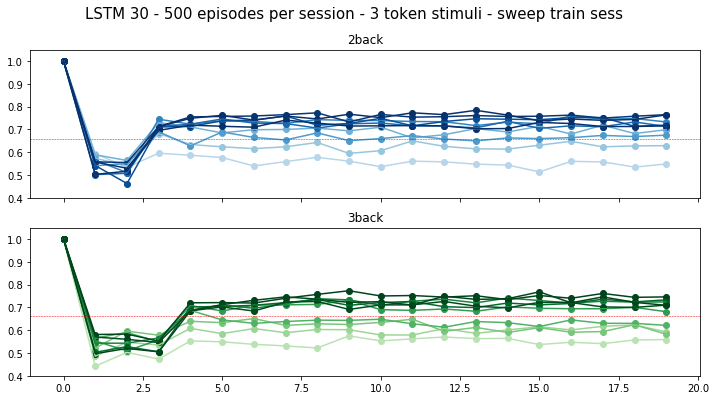

In [349]:
fig,axarr = plt.subplots(2,1,figsize=(12,6),sharex=True);axarr=axarr.reshape(-1)
for sess in range(10):
  eval_data2 = np.load("model_data/LSTM30-23back-train_eps_500-eval_2back-sess%i.npy"%(sess))
  eval_data3 = np.load("model_data/LSTM30-23back-train_eps_500-eval_3back-sess%i.npy"%(sess))
  M2 = eval_data2.mean(0)
  M3 = eval_data3.mean(0)
  axarr[0].plot(M2,c=plt.get_cmap('Blues')((sess+3)*25))
  axarr[1].plot(M3,c=plt.get_cmap('Greens')((sess+3)*25))
  axarr[0].scatter(range(20),M2,c=plt.get_cmap('Blues')((sess+3)*25))
  axarr[1].scatter(range(20),M3,c=plt.get_cmap('Greens')((sess+3)*25))

for ax in axarr:
  ax.axhline(.66,c='red',lw=.5,ls='--')
  ax.set_ylim(.4,1.05)
  
axarr[0].set_title('2back')
axarr[1].set_title('3back')
plt.suptitle('LSTM 30 - 500 episodes per session - 3 token stimuli - sweep train sess',fontsize=15)
plt.savefig('figures/LSTM30-23back_over_training')